## Основные расчетные процедуры (ARPACK)

In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import block_diag
import scipy.linalg as la

def boundary_layer_thickness(nu, u_e, x):
    return (nu*x/u_e)**0.5

def getRe_d(nu, u_e, d):
    return u_e*d/nu

def get_y(j, y):
    return y[j]

def get_U(j, vels):
    return vels[j]

def get_dudy(j, grads):
    return grads[j]

def get_h(y):
    return y[1] - y[0]

# Functions to form matrix A and B from Spatial Eigenvalues problem Ax = alpha*Bx
def getE1():
    return np.array([[0, 0, 0],
                     [1, 0, 0],
                     [0, 1, 0]])

def getE2(Re):
    return np.array([[0, 1, 0],
                     [0, 0, 0],
                     [0, 0,-Re]])

def getE3(omega, Re, dudy):
    return np.array([[0, 0, 0],
                     [1j*omega*Re, -Re*dudy, 0],
                     [0, 1j*omega*Re, 0]])

def getInvE4(omega, Re, u):
    return la.inv(np.array([[-1j, 0, 0],
                       [1j*Re*u, 0, 1j*Re],
                       [0, 1j*Re*u, 0]]))

def getA_matrix(omega, Re, N, mesh, vels, grads, comp_num = 3):
    h = get_h(mesh)
    matrix_list = list()
    
    # Form first line of matrix A
    line = list()
    y = get_y(1, mesh)
    u = get_U(1, vels)
    dudy = get_dudy(1, grads)
    invE4 = getInvE4(omega, Re, u)
    E1 = invE4@getE1()
    E2 = invE4@getE2(Re)
    E3 = invE4@getE3(omega, Re, dudy)
    L2 = E3 - 2./h**2*E1
    line.append(L2)
    L3 = 1./h**2*E1 + 1./(2*h)*E2
    line.append(L3)
    for i in range(3,N):
        line.append(np.zeros((comp_num,comp_num)))
    matrix_list.append(line)

    # Form inner lines of matrix A
    for i in range(2, N-1):
        line = list()
        y = get_y(i, mesh)
        u = get_U(i, vels)
        dudy = get_dudy(i, grads)
        invE4 = getInvE4(omega, Re, u)
        E1 = invE4@getE1()
        E2 = invE4@getE2(Re)
        E3 = invE4@getE3(omega, Re, dudy)
        for j in range(1, N):
            if j==i-1:
                L1 = 1./h**2*E1 - 1./(2*h)*E2
                line.append(L1)
            elif j==i:
                L2 = E3 - 2./h**2*E1
                line.append(L2)
            elif j==i+1:
                L3 = 1./h**2*E1 + 1./(2*h)*E2
                line.append(L3)
            else:
                line.append(np.zeros((comp_num,comp_num)))
        matrix_list.append(line)

    # Form last line of matrix A
    line = list()
    for i in range(1, N-2):
        line.append(np.zeros((comp_num,comp_num)))
    
    y = get_y(N-1, mesh)
    u = get_U(N-1, vels)
    dudy = get_dudy(N-1, grads)
    invE4 = getInvE4(omega, Re, u)
    E1 = invE4@getE1()
    E2 = invE4@getE2(Re)
    E3 = invE4@getE3(omega, Re, dudy)
    L1 = 1./h**2*E1 - 1./(2*h)*E2
    line.append(L1)
    L2 = E3 - 2./h**2*E1
    line.append(L2)
    matrix_list.append(line)

    return np.bmat(matrix_list)

## Профиль Блазиуса

Собственно все изменения надо сделать только здесь. В случае правильной реализации последний график со сперктром у вас совпадет с данными из статьи paper_data. Дополнительно проведите исследование как зависит решение от числа узлов сетки $N$. Опишите результат, приложите графики. Есть ли в спектре неустойчивые моды? Если да - укажите их.

In [4]:
import scipy.integrate as scii
import numpy as np

# свести к системы ОДУ первого порядка
def rhs(f, t):
    return np.array([f[1], f[2], -f[0] * f[2] / 2])

#blasius profile
def getMesh_U_DuDy(N, y_max):
    x = np.linspace(0, y_max, N+1)
    y = scii.odeint(rhs, np.array([0, 0, 1]), x)

    k = y[N][1]
    a = (1 / k ** (3 / 2)) ** (1 / 3)
    x = x / a
    y[:, 0] = a * y[:, 0]
    y[:, 1] = a ** 2 * y[:, 1]
    y[:, 2] = a ** 3 * y[:, 2]
    return x, y[:, 1], y[:,2]

## Постановка задачи в размерных переменных

In [5]:
mu = 1.85e-5
rho = 1.214
nu = mu/rho
u_e = 50
L = 3

omega_d = 0.26/1.72
Re_d = 1000/1.72
x = nu/u_e*Re_d**2
d = boundary_layer_thickness(nu, u_e, x)

omega = omega_d*(u_e/d)
Re = 1/nu


N = [100, 200, 300, 400, 500]
y = []
u = []
dudy = []

for n in N:
    y_d, u_d, dudy_d = getMesh_U_DuDy(n, 15) 
    y.append(y_d * d)
    u.append(u_d * u_e)
    dudy.append(dudy_d * u_e / d)

In [6]:
from scipy.sparse.linalg import eigs

A = []
eigvals, eigvec = [], []

for i in range(5):
    a = getA_matrix(omega, Re, N[i], y[i], u[i], dudy[i])
    eigva, eigve = eigs(a, 140, sigma=omega / u_e, which='LM')

    A.append(a)
    eigvals.append(eigva * d)
    eigvec.append(eigve)

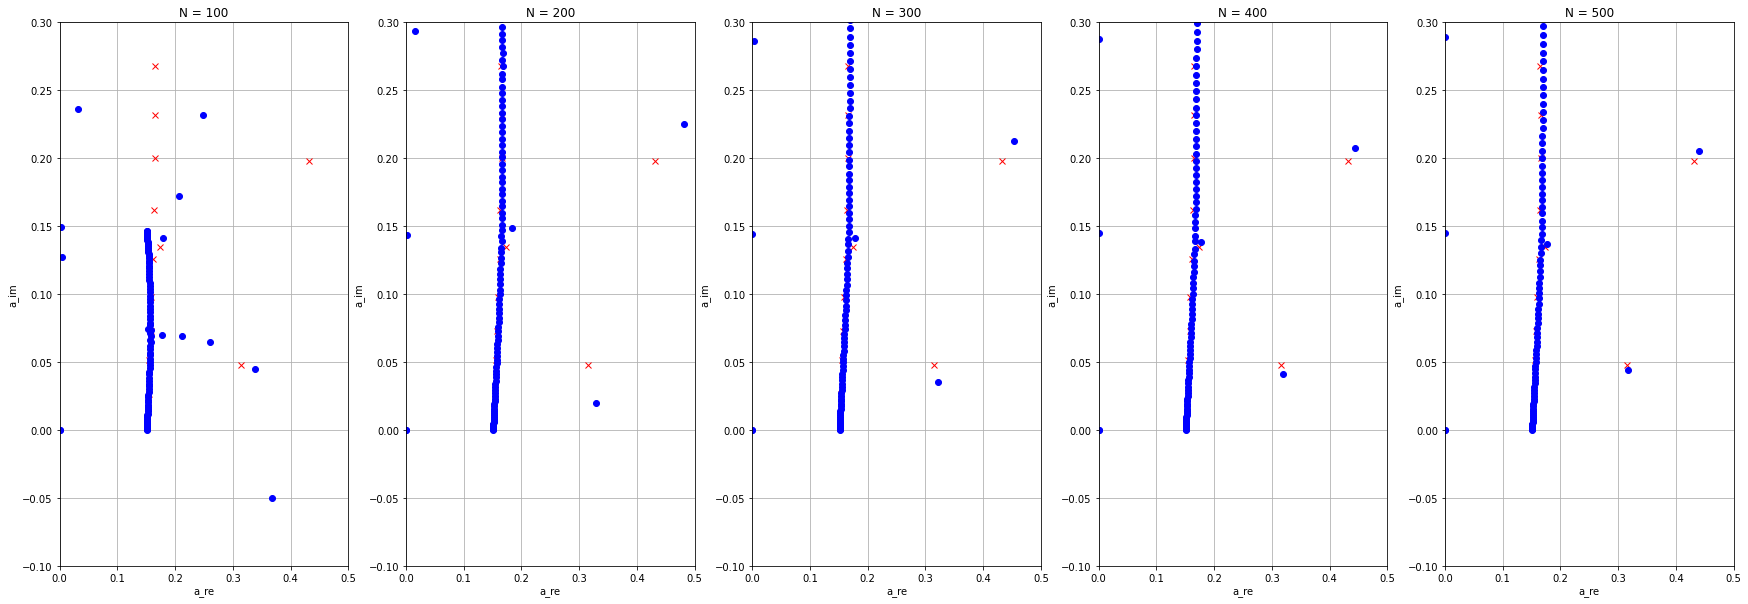

In [11]:
%matplotlib inline 
import matplotlib.pyplot as plt

paper_data = np.array([[0.2600153645394847,0.005216576864792044],
                       [0.2649509597575349,0.04520717573104338],
                       [0.267293525846102,0.08786938036706515],
                       [0.2709547061794915,0.12519574002357303],
                       [0.2732972722680586,0.1678579446595948],
                       [0.27947781613066175,0.2158461721950946],
                       [0.28170988381882467,0.27850858730426],
                       [0.28521636639164843,0.3438352416231689],
                       [0.28491433743054384,0.3985024835830948],
                       [0.28456810910927766,0.46116980973227817],
                       [0.28552576191277995,0.5211679856317001],
                       [0.29872663748105743,0.23180950777347475],
                       [0.5419115170904193,0.08201296514564738],
                       [0.7428786411853847,0.3402968372902284],
                       [0.28653498063647076,0.5718327299769883]])

paper_data /= 1.72


plt.subplots(1, 5, figsize=(30, 10))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.plot(paper_data[:,0], paper_data[:,1], 'xr', label='Paper') # test case for omega = 0.26
    plt.plot(eigvals[i].real, eigvals[i].imag, 'ob', label='Numerical')
    #plt.legend()
    plt.xlim(0, 0.5)
    plt.ylim(-0.1, 0.3)
    # plt.xlim(0, 1)
    # plt.ylim(0, 10)
    plt.grid() 
    plt.xlabel('a_re')
    plt.ylabel('a_im')
    plt.title(f'N = {N[i]}')

plt.show()

В спектре нет неустойчивых мод. Для N = 200, 300, 400, 500 получим схожие графики спектров.